The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Relative L2 error: 7.2494e-02


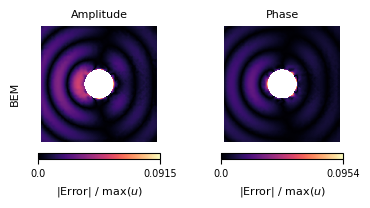

In [9]:
# reload kernel
%load_ext autoreload
%autoreload 2

import sys
import os

# Set the current directory and utilities path
current_dir = os.getcwd()
utilities_dir = os.path.join(current_dir, '../../utilities')

# Change the working directory to the notebook's directory
os.chdir(current_dir)

# Modify the module search path to include utilities directory
sys.path.insert(0, utilities_dir)

from analytical_solution_functions import sound_hard_circle_calc 
from analytical_solution_functions import mask_displacement

from bem_solution_functions import Circle_n
from bem_solution_functions import solveExteriorBoundary
from bem_solution_functions import solveExterior
from bem_solution_functions import generateInteriorPoints_excluding_circle
from plotting_functions import plot_bem_error

import numpy as np
from scipy.interpolate import griddata

"""
Problem setup
"""

k = 3.0               # Wave number
n = 15                # Number of boundary elements (circular discretization)
n_dom = 40            # Number of domain sampling points (per axis)
r_exclude = np.pi / 4 # Radius of excluded circular region
l_se = np.pi          # Half-length of the computational domain
n_grid = 501          # Number of grid points along x and y

"""
Generate circular boundary mesh
"""

aVertex, aElement = Circle_n(n=n, radius=r_exclude)
num_elements = aElement.shape[0]
aCenters = 0.5 * (aVertex[aElement[:, 0]] + aVertex[aElement[:, 1]])
theta = np.arctan2(aCenters[:, 1], aCenters[:, 0])  # Normal angle at each element center

"""
Apply Neumann boundary conditions
"""

alpha = np.full(num_elements, 0.0, dtype=complex)
beta  = np.full(num_elements, 1.0, dtype=complex)
f     = np.empty(num_elements, dtype=complex)
phi   = np.full(num_elements, 0.0, dtype=complex)
v     = np.full(num_elements, 0.0, dtype=complex)

# Compute incident field and its normal derivative
kx = k * aCenters[:, 0]
phi_inc = np.exp(1j * kx)
f = -1j * k * np.cos(theta) * phi_inc  # ∂φ_inc/∂n = i k cos(θ) φ_inc

"""
Generate interior points, excluding the circular obstacle
"""

points_outside, points_inside = generateInteriorPoints_excluding_circle(
    Nx=n_dom, Ny=n_dom,
    xmin=-l_se, xmax=l_se,
    ymin=-l_se, ymax=l_se,
    r_exclude=r_exclude
)
interiorIncidentPhi = np.zeros(points_outside.shape[0], dtype=complex)

"""
Solve boundary integral equation (exterior problem)
"""

c, density = None, None
v, phi = solveExteriorBoundary(
    k, alpha, beta, f, phi, v,
    aVertex, aElement,
    c, density,
    'exterior'
)

"""
Evaluate scattered field at interior points
"""

interiorPhi = solveExterior(
    k, v, phi,
    interiorIncidentPhi,
    points_outside,
    aVertex, aElement,
    'exterior'
)

"""
Interpolate scattered field on a uniform grid
"""

Y, X = np.mgrid[-l_se:l_se:n_grid*1j, -l_se:l_se:n_grid*1j]
grid_z = griddata(points_outside, interiorPhi, (X, Y), method='cubic')
grid_z = np.ma.masked_where(np.sqrt(X**2 + Y**2) < r_exclude, grid_z)

# Extract real and imaginary parts
u_scn_amp = grid_z.real   # Scattered field amplitude
u_scn_phase = grid_z.imag # Scattered field phase

"""
Compute analytical solution for a sound-hard circular obstacle
"""

R_exact = np.sqrt(X**2 + Y**2)  # Radial distance from origin
u_inc_exact, u_scn_exact, u_exact = sound_hard_circle_calc(k, r_exclude, X, Y, n_terms=None)

"""
Mask exact solution inside the circular obstacle
"""

u_inc_exact = mask_displacement(R_exact, r_exclude, l_se, u_inc_exact)
u_scn_exact = mask_displacement(R_exact, r_exclude, l_se, u_scn_exact)
u_exact     = mask_displacement(R_exact, r_exclude, l_se, u_exact)

"""
Compute relative L2 error (real part of scattered field)
"""

# Create masked copies to zero-out interior region
R_grid = np.sqrt(X**2 + Y**2)
u_scn_exact_masked = np.copy(u_scn_exact)
u_scn_amp_masked   = np.copy(u_scn_amp)
u_scn_exact_masked[R_grid < r_exclude] = 0
u_scn_amp_masked[R_grid < r_exclude] = 0

relative_error = np.linalg.norm(u_scn_exact_masked.real - u_scn_amp_masked.real, 2) / \
                 np.linalg.norm(u_scn_exact_masked.real, 2)
print(f"Relative L2 error: {relative_error:.4e}")

"""
Visualize the BEM error in amplitude and phase
"""

plot_bem_error(
    X, Y,
    u_scn_amp,
    np.real(u_inc_exact) + u_scn_amp,
    np.abs(np.real(u_scn_exact) - u_scn_amp),
    u_scn_phase,
    u_scn_phase + np.real(u_inc_exact),
    np.abs(np.imag(u_scn_exact) - u_scn_phase)
)
